<table style="width: 100%;" id="nb-header">
    <tr style="background-color: transparent;"><td>
        <img src="https://d8a-88.github.io/econ-fa19/assets/images/blue_text.png" width="250px" style="margin-left: 0;" />
    </td><td>
        <p style="text-align: right; font-size: 12pt;"><strong>Economic Models</strong>, Fall 2019<br>
            Dr. Eric Van Dusen</p></td></tr>
</table>

# Project 1: Modeling Macroeconomic Variables using the Cobb-Douglas Production Function

## Acknowledgements: ##
We would like to thank Professor Raymond Hawkins for his Economics 100B Problem Set that served as the basis for this assignment.

## Due Dates and Important Information:

- This project is in three parts.
- The whole project (all three parts) will be due 2 Mondays from now, on March 16, 2020 at 11:59pm on Gradescope.
- **Do not change any of the given variable or function names as this would cause autograder problems. Make sure to name your columns and tables exactly as the questions ask you to.**

---

The goal of this homework is to gain experience completing the following key steps in the data science pipeline:

1. Cleaning and filtering data collected from online sources
2. Identifying and visualizing overall trends in the data using a process called Exploratory Data Analysis (EDA)
3. Using the data to complete a problem of prediction

We hope that at the end of this project, you will see how the skills you have learned in Data 8 and this class can prepare you for dealing with real world datasets, and how you can use them to answer questions about the economy or the world.

## The question you will be answering today is the following: How can we apply the Cobb-Douglas Production Function to understand the different ways countries produce output or GDP?

# Part 1: Simplifying the problem

In [1]:
from utils import *
import pandas as pd
from datascience import *
from sympy import *
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.linear_model import LinearRegression
import otter
grader = otter.Notebook()
%matplotlib inline
plt.style.use("seaborn-notebook")

In [2]:
### Edit the line below ###
file_name = "pwt91.csv"

### Do not change the line below ###
data = to_table(file_name)

Now, this dataset is saved under the table called ```data```. Look at the first 5 lines below:

In [4]:
data.show(5)

countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,ccon,cda,cgdpe,cgdpo,cn,ck,ctfp,cwtfp,rgdpna,rconna,rdana,rnna,rkna,rtfpna,rwtfpna,labsh,irr,delta,xr,pl_con,pl_da,pl_gdpo,i_cig,i_xm,i_xr,i_outlier,i_irr,cor_exp,statcap,csh_c,csh_i,csh_g,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k
ABW,Aruba,Aruban Guilder,1950,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
ABW,Aruba,Aruban Guilder,1951,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
ABW,Aruba,Aruban Guilder,1952,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
ABW,Aruba,Aruban Guilder,1953,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
ABW,Aruba,Aruban Guilder,1954,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


Notice that there are a lot of ```-1``` values. These are representative of data being unavailable for that variable, for a given country-year.

To get an idea of the dataset's geographic scope, let us find out what countries are included, and if they are spelt in interesting ways. This will be helpful for us later on in our analysis.

<div class="alert alert-info">
    
<h3> Question 1.1. </h3>
Create a two-column table called <code>all_countries</code>. Its first column will be called <code>Country</code> and the second <code>Earliest Year</code>. It should contain all of the countries that appear in the <code>data</code> table sorted in alphabetical order with the earliest year they appear in the dataset where the <code>cgdpe</code> column is not <code>-1</code>. Assign that table to the variable <code>all_countries</code> and display its first 10 rows.
</div>

In [5]:
all_countries = ...

### Solution ###
all_countries = data.where("cgdpe", are.above(-1)).group("country", min).select("country", "year min").relabel("country", "Country").relabel("year min", "Earliest Year")
all_countries.show(10)

Country,Earliest Year
Albania,1970
Algeria,1960
Angola,1970
Anguilla,1970
Antigua and Barbuda,1970
Argentina,1950
Armenia,1990
Aruba,1970
Australia,1950
Austria,1950


In [6]:
grader.check("q1_1")

Take a look at ```data``` again. Notice that it has a lot of columns. We won't need most of them. As we will be using the Cobb-Douglas Production Function, think about what variables are needed in the equation, and which ones are already present in the table. This is an important part of the data science process: understanding the dataset that you are using. Most real-world datasets provide documentation listing the definitions and equations behind each variable. 

PWT provides this and has identified three variables that will be helpful to us:
1. cn $\Rightarrow$ Capital Stock in millions of USD
2. cgdpe $\Rightarrow$ Expenditure-side Real GDP in millions of USD
3. emp $\Rightarrow$ Number of Persons employed in millions

**An important note: for the sake of simplicity, we will be assuming that nations exhibit constant returns to scale.**

<div class="alert alert-info">
    
<h3> Question 1.2(a). </h3>
In the text cell below do the following: <br />
1. Rewrite the original Cobb-Douglas function in LaTeX, under the assumption that are no constant returns to scale. On a separate line, write the restriction implied by constant returns to scale. <br />
2. Give a brief explanation of what each variable in the Cobb-Douglas function quantifies (i.e. K measures the amount of ...)
</div>

** Your answer here **

Solution:


1)
$$
Y = A K^\alpha L^\beta \\
\alpha + \beta = 1
$$

2)
- Y measures the dollar value of goods and services produced in a country
- A measures total factor productivity: how effectively a country uses its inputs in producing output
- K measures the amount of capital in a country
- L measures the amount of labor in a country
- $\alpha$ measures how much emphasis is placed on capital and 1 - $\alpha$ or $\beta$ is for labor

<div class="alert alert-info">
    
<h3> Question 1.2(b). </h3>
Assign the variable <code>missing_variables</code> to an array containing the Cobb-Douglas function variables that are missing from the dataset.
</div>

In [7]:
### Your code here ###

missing_variables = ...

### Solution ###
missing_variables = make_array("A", "alpha")

In [8]:
grader.check("q1_2b")

<div class="alert alert-info">
    
<h3> Question 1.3. </h3>
Remove all columns from <code>data</code> except for <code>cn</code>, <code>cgdpe</code>, <code>emp</code>, <code>country</code> and <code>year</code>. Ensure that <code>country</code> and <code>year</code> are the two left-most columns respectively. Call the new table <code>cleaned_data</code> and display its first five rows. Rename the <code>cn</code> column to <code>Capital Stock</code>, <code>cgdpe</code> to <code>Real GDP</code> and <code>emp</code> to <code>Labor Force</code>.
</div>

In [9]:
### Your code here ###
cleaned_data = ...

### Solution ###
cleaned_data = data.select("country", "year", "cn", "cgdpe", "emp")
cleaned_data.relabel("cn", "Capital Stock").relabel("cgdpe", "Real GDP").relabel("emp", "Labor Force")
###

cleaned_data.show(5)

country,year,Capital Stock,Real GDP,Labor Force
Aruba,1950,-1,-1,-1
Aruba,1951,-1,-1,-1
Aruba,1952,-1,-1,-1
Aruba,1953,-1,-1,-1
Aruba,1954,-1,-1,-1


In [10]:
grader.check("q1_3")

Our goal will be to predict what $\alpha$ and $A$ are for each of the countries that we will be examining. From these, we will be able to explore how output is produced in each of these countries. The question is, how can we use the Cobb-Douglas Production function to solve for the missing variables? An easy way would be to take the natural log of the equation, making it linear, providing us with ways to quantify $\alpha$ and $A$.

<div class="alert alert-info">

<h3>Question 1.4.</h3>
In the cell below, using LaTeX, take the natural log of the Cobb-Douglas Production Function and rewrite it as a function of one variable. Show all of your work. Full credit will not be given if you just display the final simplified equation without showing any work. <br />
<i> Hint: $\ln (Y) - \ln (L) = \text{...}$. </i>
</div>

** Your LaTeX here **

Solution: They see this relationship in the data. Then, they see the intercept to be A and the slope to be $\alpha$.
$$
\ln(Y) = \ln(A) + \alpha \ln(K) + (1 - \alpha) \ln(L) \\
\ln(Y) = \ln(A) + \alpha \left ( \ln(K) - \ln(L) \right ) + \ln(L) \\
\ln \left (\dfrac{Y}{L} \right ) = \ln(A) + \alpha \ln \left ( \dfrac{K}{L} \right )
$$
From there, they can do this for all the countries then compare their values.

# Part 2: Exploring the Data

Whenever we are dealing with a large dataset like PWT, it is a good idea to see how the variables interact with each other. A common method, especially when dealing with economic data, is to generate a time series. This is a plot of some economic variable on the y-axis and time on the x-axis. We are going to do just that for our important Cobb-Douglas variables for different countries.

<div class="alert alert-info">
    
<h3>Question 2.1.</h3> 
Create a table of GDP, Capital Stock and Labor for the USA from 1990 to 2017. Do the same for China and two other countries of your choice. Use the middle cell to check if your countries of choice exist in the dataset. Make sure to use the country name exactly as it appears in the data table. Place all of this data in one table called <code>comparison_data</code>. Display the first 10 rows of <code>comparison_data</code>. Additionally, set the <code>country_array</code> variable to an array of the countries you selected in alphabetical order. <br />
<i>Hint: Look at the <a href="https://d8a-88.github.io/econ-fa19/python-reference.html"> Python Reference</a> for a table function you can use.</i>
</div>

In [11]:
### Run this cell to see a table of all the countries in the dataset.###
### Select two countries and proceed to the lower code cell. ###
all_countries.show()

Country,Earliest Year
Albania,1970
Algeria,1960
Angola,1970
Anguilla,1970
Antigua and Barbuda,1970
Argentina,1950
Armenia,1990
Aruba,1970
Australia,1950
Austria,1950


In [12]:
### Your code here ###
country_array = make_array("China", "United States", ..., ...)
comparison_data = ...

### Solution ###
country_array = make_array("China", "Philippines", "Senegal", "United States")
comparison_data = cleaned_data.where("country", are.contained_in(country_array)).where("year", are.between(1990, 2018))

In [13]:
grader.check("q2_1")

**Note:** If you ever need to refer to a list of the countries you selected in your code, do **not** use ```country_array```. When you place the data in ```comparison_data```, Python will automatically re-order the countries. Using ```country_array``` will cause a mis-match between your rows of data in ```comparison_data``` and the country it is actually from.

<div class="alert alert-info">
    
<h3>Question 2.2.</h3>
To help us in later questions, fill in the blanks in the <code>country_table_plotter</code> function below. Its inputs will be a table of the form <code>comparison_data</code> and the names of the two columns plotted, <code>columnX</code> and <code>columnY</code>. The <code>country_table_plotter</code> function will plot <code>columnX</code> versus <code>columnY</code> using data from <code>data_table</code> for all the countries contained in <code>data_table</code>. <br />
<i> Hint: Look at the <a href="https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html"> Matplotlib Plotting Reference</a> for ideas of what to place in the blanks. </i>
</div>

In [14]:
def country_table_plotter(data_table, columnX, columnY):
    
#     ### Your code here ###
#     for country in ...:
#         plt.plot(..., ..., label = country, linewidth = 1)
    
    ### Solution ###
    countries = data_table.group("country").column("country")
    for country in countries:
        current_country_table = data_table.where("country", country)
        plt.plot(current_country_table.column(columnX), current_country_table.column(columnY), 
                 label = country, linewidth = 1.5)
    
    
    ### Do not change the code below ###
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'x-large')
    plt.xlabel(columnX)
    plt.ylabel(f"{columnY} (Logarithmic Scale)")
    plt.yscale("log")

<div class="alert alert-info">
    
<h3>Question 2.3.</h3>
Produce a plot of time and capital stock for the countries in your table. In the markdown cell below your plot, identify differences between the countries and discuss what surprised you.
</div>

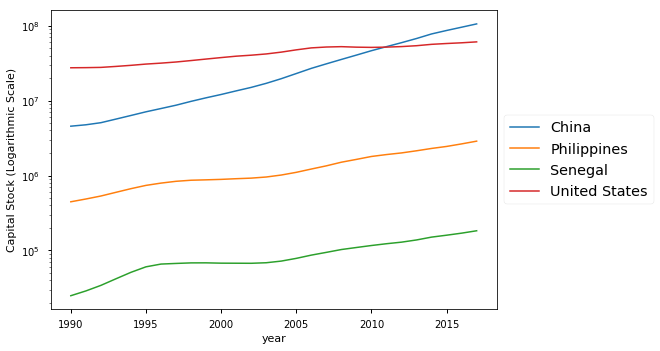

In [15]:
### Your code here ###
...

### Solution ###
country_table_plotter(comparison_data, "year", "Capital Stock")

- United States:

- China:

- Your Country:

- Your Country:

<div class="alert alert-info">
    
<h3>Question 2.4.</h3>
Produce a similar plot, but this time of time and labor for the countries in your table. In the markdown cell below your plot, identify differences between the countries and discuss what surprised you.
</div>

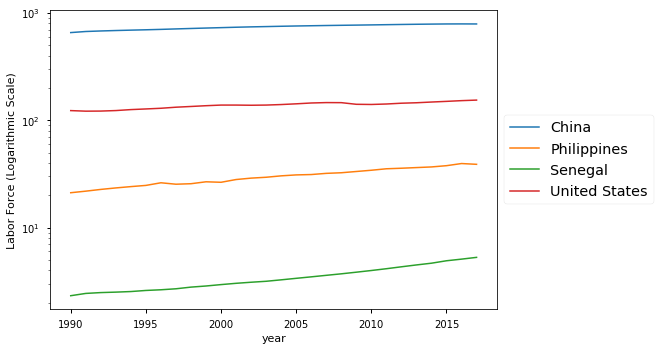

In [16]:
### Your code here ###
...

### Solution ###
country_table_plotter(comparison_data, "year", "Labor Force")

- United States:

- China:

- Your Country:

- Your Country:

<div class="alert alert-info">
    
<h3>Question 2.5.</h3>
Create a plot of time and GDP for the countries in your table. In the text cell below your plot, using your knowledge of the Cobb-Douglas Production Function, identify differences between the countries and discuss these in relation to your findings about each of the country's levels of capital stock and labor. Also note about how these have changed over time, if at all.
</div>

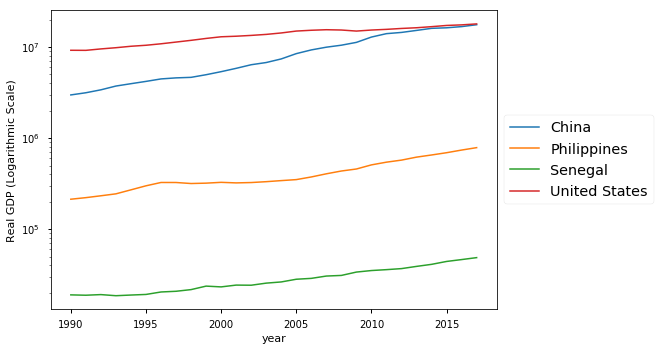

In [17]:
### Your code here ###
...

### Solution ###
country_table_plotter(comparison_data, "year", "Real GDP")

- United States:

- China:

- Your Country:

- Your Country:

---

# Part 3: Prediction and Comparison

We are now going to provide numerical backing to your discussions of differences between the nations. We will predict values for $\alpha$ and $A$ for each of the 4 countries that we are examining. To do this, we will revisit the equation that you derived in question 1.4. 

<div class="alert alert-info">
    
<h3>Question 3.1.</h3>
A key step in the original paper by Cobb and Douglas was that they converted the data into an index. This is important because the data is measured in different units. Do this for each country and each of the variables in <code>comparison_data</code>. Let the 2011 value for each variable in each country be the base year, i.e. 100. Place this in a new table called <code>indexed_data</code> together with <code>country</code> and <code>year</code> columns. Display the first few rows. <br />
<i>Hint: The formula for calculating an index is as follows:
$$
\dfrac{Q_{\text{current year}}}{Q_{\text{base year}}} \cdot 100 \, \text{ for some variable } Q
$$</i>
</div>

In [18]:
## Replace the ... in the code below ###
# base_values = ...
# countries = ...
# indexed_Ks = make_array()
# indexed_Ls = make_array()
# indexed_Ys = make_array()

# for country in countries:
#     ...
    
# indexed_data = Table().with_columns("country", ...
#                                    "year", ...
#                                    "Indexed K", ...
#                                    "Indexed L", ...
#                                    "Indexed Y", ...
#                                    )

# indexed_data.show(5)

### Solution ###
base_values = comparison_data.where("year", 2011)
countries = comparison_data.group("country").column("country")
indexed_Ks = make_array()
indexed_Ls = make_array()
indexed_Ys = make_array()

for country in countries:
    country_base_values = base_values.where("country", country)
    curr_Ks = comparison_data.where("country", country).column("Capital Stock") / country_base_values.column("Capital Stock") * 100
    curr_Ls = comparison_data.where("country", country).column("Labor Force") / country_base_values.column("Labor Force") * 100
    curr_Ys = comparison_data.where("country", country).column("Real GDP") / country_base_values.column("Real GDP") * 100
    indexed_Ks = np.append(indexed_Ks, curr_Ks)
    indexed_Ls = np.append(indexed_Ls, curr_Ls)
    indexed_Ys = np.append(indexed_Ys, curr_Ys)

indexed_data = Table().with_columns("country", comparison_data.column("country"), "year", comparison_data.column("year"),
                    "Indexed K", indexed_Ks, "Indexed L", indexed_Ls, "Indexed Y", indexed_Ys)

indexed_data.show(9)

country,year,Indexed K,Indexed L,Indexed Y
China,1990,8.67161,84.4034,21.2439
China,1991,9.05109,86.3807,22.4446
China,1992,9.65506,87.3824,24.1699
China,1993,10.7832,88.2054,26.5915
China,1994,12.0524,88.9376,28.2215
China,1995,13.495,89.6196,29.9083
China,1996,14.9247,90.3957,31.8366
China,1997,16.5313,91.2963,32.6932
China,1998,18.6067,92.1745,33.13


In [19]:
grader.check("q3_1")

In [20]:
grader.check("q3_1H")

AssertionError: Test q3_1H does not exist

<div class="alert alert-info">
    
<h3>Question 3.2(a).</h3>
Using the equation you derived in part 1 and the <code>indexed_data</code> table, calculate the two log ratios that you need to perform linear regression. Place them in the table <code>log_ratios</code> with <code>country</code> and <code>year</code> as the two leftmost columns respectively. Display the first 10 rows and name the columns appropriately. The <code>log_ratios</code> table should have 4 columns.
</div>

In [21]:
### Your code here ###
log_ratios = ...

### Solution ###
log_ratios = Table().with_columns("country", indexed_data.column("country"),
                                  "year", indexed_data.column("year"),
                                  "ln(Y/L)", np.log(indexed_data.column("Indexed Y")/indexed_data.column("Indexed L")),
                                  "ln(K/L)", np.log(indexed_data.column("Indexed K")/indexed_data.column("Indexed L")))
###

log_ratios.show()

country,year,ln(Y/L),ln(K/L)
China,1990,-1.37954,-2.27555
China,1991,-1.34772,-2.25588
China,1992,-1.28518,-2.20281
China,1993,-1.19908,-2.10168
China,1994,-1.14785,-1.99867
China,1995,-1.09744,-1.89325
China,1996,-1.04358,-1.80118
China,1997,-1.02694,-1.70885
China,1998,-1.02324,-1.60016
China,1999,-0.965746,-1.50015


In [ ]:
grader.check("q3_2a")

In [ ]:
grader.check("q3_2aH")

<div class="alert alert-info">
    
<h3>Question 3.2(b).</h3>
Using the <code>country_table_scatter</code> function, plot the log ratios for each country from the <code>log_ratios</code> table below.
</div>

In [26]:
### Do not change the code below ###

def country_table_scatter(data_table, columnX, columnY):
    # First getting a list of all the countries in data_table
    country_list = data_table.group("country").column("country")
    
    # For each country, creating a scatter plot of columnX vs. columnY
    for country in country_list:
        curr_data_table = data_table.where("country", country)
        curr_data_table.scatter(columnX, columnY)
        plt.title(country)

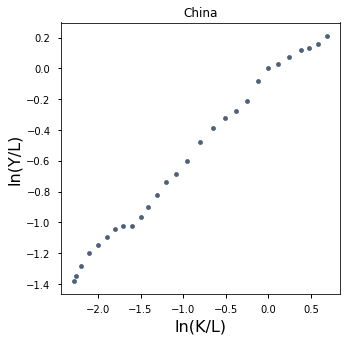

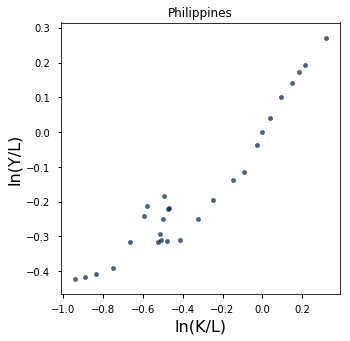

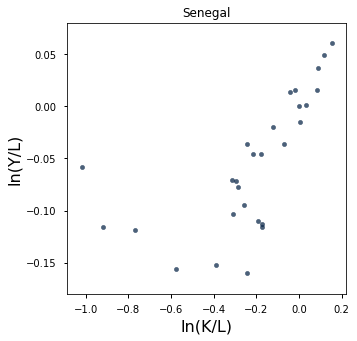

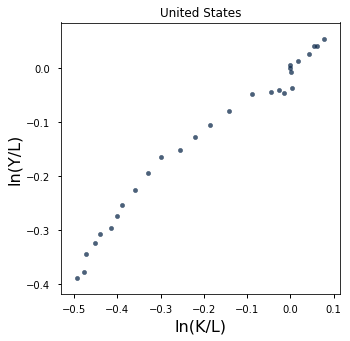

In [27]:
### Your code here ###
...

### Solution ###
country_table_scatter(log_ratios, "ln(K/L)", "ln(Y/L)")

<div class="alert alert-info">

<h3>Extra Credit</h3>
What do you notice about the scatter plot for the US? What could be a possible reason for this?
</div>

** Your answer here **

To help you compare, the code below will plot all of the scatter plots on the same axis. Remember, the axes are in terms of logarithms. Thus, even small differences in slope or intercepts would yield big changes.

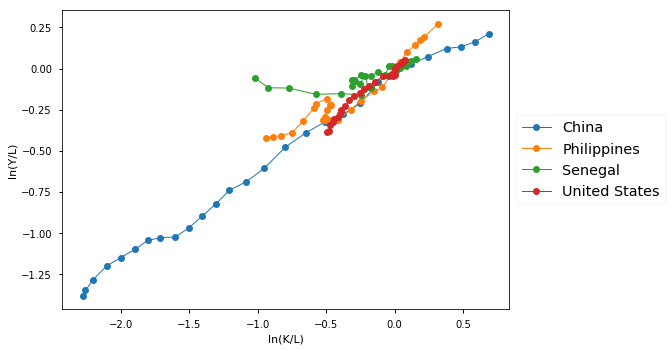

In [28]:
### Do not change the code below ###
all_scatter(log_ratios, "ln(K/L)", "ln(Y/L)")

Now, we want to make a linear approximation of the curves above. How will we do this? Through linear regression.

We will be using Scikit-Learn's (Sk-learn) linear regression function to get the $\alpha$ and $A$ values for each country. Here is the link to the documentation of the <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html"> function</a>: 

Let us break down how this function works by taking a look at the examples section of the documentation.
``` 
import numpy as np
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)
```
The ```LinearRegression()``` function creates a LinearRegression object that has many different functions that we will be using, mainly ```.fit()``` and attributes like ```.coef_``` and ```.intercept_```. The ```.fit(X, y)``` function fits a line using the ```X``` and ```y``` arrays passed into it.

```
reg.coef_
array([1., 2.])
reg.intercept_ 
3.0000...
reg.predict(np.array([[3, 5]]))
array([16.])
```

After we have fit a line to the data, we can then get the corresponding attributes that we need: the slope coefficient and intercept. Note: the above example uses the equation:

$$
y = ax_0 + bx_1 + c
$$

Its data is in 3 dimensions, $x_0$, $x_1$ and $y$. Thus, ```reg.coef_``` returns a two element array, as there are two slope coefficients for x_0 and x_1. ```reg.intercept_``` still returns the intercept of the fitted line.

Our data is in 2 dimensions, x and y. Thus, the function will attempt to fit the following line for each country:

$$
y = a + bx
$$

The function will find the values of $a$ and $b$ that minimize the squared errors at each value of $x$. You don't need to know the specifics of this just yet. Your task will be to figure out what arrays should be passed in as $y$ and $x$. Furthermore, think about the relationship between $\alpha$ and $A$ with regards to $a$ and $b$ from this linear regression fit.

<div class="alert alert-info">

<h3>Question 3.3a.</h3>
Using Sklearn's Linear Regression function, fit the data taken from each country. Think about what should be passed into the <code>fit()</code> function. If you are confused about this, take a look at the sklearn <a href ="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit"> documentation</a> or the example above.        

</div>

In [29]:
### Create arrays of the data we will need from each country. ###
### Think about which variable should be on each axis. ###

china_x = ...
china_y = ...
us_x = ...
us_y = ...
country1_x = ...
country1_y = ...
country2_x = ...
country2_y = ...

### Solution ###

china_x = log_ratios.where("country", "China").column("ln(K/L)")
china_y = log_ratios.where("country", "China").column("ln(Y/L)")
us_x = log_ratios.where("country", "United States").column("ln(K/L)")
us_y = log_ratios.where("country", "United States").column("ln(Y/L)")
country1_x = log_ratios.where("country", "Senegal").column("ln(K/L)")
country1_y = log_ratios.where("country", "Senegal").column("ln(Y/L)")
country2_x = log_ratios.where("country", "Philippines").column("ln(K/L)")
country2_y = log_ratios.where("country", "Philippines").column("ln(Y/L)")

### Do not change the code below ###

model_china = LinearRegression().fit(china_x.reshape(-1, 1), china_y.reshape(-1, 1))
model_us = LinearRegression().fit(us_x.reshape(-1, 1), us_y.reshape(-1, 1))
model_country1 = LinearRegression().fit(country1_x.reshape(-1, 1), country1_y.reshape(-1, 1))
model_country2 = LinearRegression().fit(country2_x.reshape(-1, 1), country2_y.reshape(-1, 1))

In [30]:
grader.check("q3_3a")

In [31]:
grader.check("q3_3aH")

<div class="alert alert-info">
    
<h3>Question 3.3b.</h3>
Now that we have fit the data of each country, we can then retrieve the slope and intercept of each fit. Using the equation you derived in question 1.3., fill in the blanks in the print statements below such that they display the $\alpha$ and $A$ values for each country. Note that you will need to transform at least one of the variables.
</div>

In [32]:
### Your code here ###

print(f"China alpha value: {...}")
print(f"United States alpha value: {...}")
print(f"... alpha value: {...}")
print(f"... alpha value: {...}")

### Solution ###
print(f"China alpha value: {model_china.coef_}")
print(f"United States alpha value: {model_us.coef_}")
print(f"Senegal alpha value: {model_country1.coef_}")
print(f"Philippines alpha value: {model_country2.coef_}")

China alpha value: Ellipsis
United States alpha value: Ellipsis
... alpha value: Ellipsis
... alpha value: Ellipsis
China alpha value: [[0.54916526]]
United States alpha value: [[0.69166852]]
Senegal alpha value: [[0.14339235]]
Philippines alpha value: [[0.54050073]]


In [33]:
### Your code here ###

print(f"China A value: {np.exp(model_china.intercept_)}")
print(f"United States A value: {np.exp(model_us.intercept_)}")
print(f"Senegal A value: {np.exp(model_country1.intercept_)}")
print(f"Philippines A value: {np.exp(model_country2.intercept_)}")

China A value: [0.92126063]
United States A value: [0.9995846]
Senegal A value: [0.97808331]
Philippines A value: [1.01697701]


<div class="alert alert-info">
    
<h3>Question 3.4.</h3>
With reference to the $\alpha$ and $A$ values for each of the countries you have examined, do they indicate about that country's ability to produce output as measured through GDP? Compare and contrast how each country allocates capital and labor when producing output. How about the role of technology or research and development? 3-4 sentences should suffice.
</div>

** Your answer here **

# Congratulations! You've completed the project!

# Submission

To turn in this project, go to File > Download As, select Notebook and upload this .ipynb file to Gradescope under Project 1 Final Submission - Notebook. Then, go to File > Download As, select PDF via Chrome and upload that PDF to Gradescope under Project 1 Final Submission - PDF.